In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/lemma.csv')

print(df.isnull().sum())
df.dropna(subset=['lemmatized_text'], inplace=True)
print(df.isnull().sum())

Sınıf                0
lemmatized_text    126
dtype: int64
Sınıf              0
lemmatized_text    0
dtype: int64


In [4]:
import re

def deleteunk(text):
    return re.sub(r'\bUNK\b','', text)

df["lemmatized_text"] = df["lemmatized_text"].apply(deleteunk)

In [5]:
toplam_token_sayisi = df['lemmatized_text'].apply(len).sum()
print(f"Toplam token sayısı: {toplam_token_sayisi}")

Toplam token sayısı: 1440389034


In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df['token'] = df['lemmatized_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
toplam_token_sayisi = df['token'].apply(len).sum()
print(f"Toplam token sayısı: {toplam_token_sayisi}")

Toplam token sayısı: 245255839


In [8]:
# Silinecek tokenler listesi
silinecek_tokenler = ['ol', 'et', 'yap', 'ben', 'ver', 'al', 'de', 'gel', 'yıl', 'gün', 'kendi', 'çık', 'söyle', 'ara', 'iş', 'var', 'son', 'yer', 'gör', 'git', 'başla', 'ilk', 'bulun', 'başkan', 'konu', 'türkiye', 'kullan', 'yüz', 'çalış']

# Her satırda silinecek tokenleri df['token'] sütunundan çıkaralım
df['temiz_text'] = df['token'].apply(lambda x: [token for token in x if token not in silinecek_tokenler])

In [9]:
toplam_token_sayisi = df['temiz_text'].apply(len).sum()
print(f"Toplam token sayısı: {toplam_token_sayisi}")

Toplam token sayısı: 210577354


In [10]:
from sklearn.model_selection import train_test_split

max_words = 200000000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['temiz_text'])
X = tokenizer.texts_to_sequences(df['temiz_text'])
X = pad_sequences(X, maxlen=max_len)
y = np.array(df['Sınıf'])



In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)




In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)


from keras.utils import to_categorical

num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)


In [13]:
print(y_train_categorical.shape)
print(y_test_categorical.shape)
print(y_val_categorical.shape)

(891529, 9)
(297177, 9)
(297177, 9)


In [14]:
embedding_dim = 5
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
epochs = 8

batch_size = 8192


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 5)            1000000000
                                                                 
 spatial_dropout1d (Spatial  (None, 500, 5)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               68608     
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 1000069769 (3.73 GB)
Trainable params: 1000069769 (3.73 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train_categorical, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_categorical), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/8
109/109 [==============================] - 1851s 17s/step - loss: 1.7510 - accuracy: 0.3753 - precision: 0.7092 - recall: 0.1119 - val_loss: 1.2624 - val_accuracy: 0.5567 - val_precision: 0.7928 - val_recall: 0.3658
Epoch 2/8
109/109 [==============================] - 1811s 17s/step - loss: 1.0344 - accuracy: 0.6630 - precision: 0.8539 - recall: 0.5128 - val_loss: 0.7826 - val_accuracy: 0.7428 - val_precision: 0.8941 - val_recall: 0.6667
Epoch 3/8
109/109 [==============================] - 1812s 17s/step - loss: 0.7705 - accuracy: 0.7440 - precision: 0.8887 - recall: 0.6709 - val_loss: 0.6483 - val_accuracy: 0.7868 - val_precision: 0.9112 - val_recall: 0.7152
Epoch 4/8
109/109 [==============================] - 1801s 17s/step - loss: 0.6749 - accuracy: 0.7787 - precision: 0.9027 - recall: 0.6960 - val_loss: 0.5568 - val_accuracy: 0.8196 - val_precision: 0.9070 - val_recall: 0.7576
Epoch 5/8
109/109 [==============================] - 1808s 17s/step - loss: 0.6056 - accuracy: 0

In [17]:
model.save('nlp_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
tf.keras.models.save_model(model, 'nlp_model.hdf5')

<ipython-input-18-7bcaf00ffa2b>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, 'nlp_model.hdf5')


In [53]:
drive.mount('/content/drive')

import os

# Hedef klasörün yolu
drive_path = '/content/drive/MyDrive/data'

# Klasör mevcut değilse oluştur
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

import shutil

# model.hdf5 dosyasını kaydetmek istediğiniz yol
destination_path = os.path.join(drive_path, 'nlp_model.hdf5')

# model.hdf5 dosyasını belirlediğiniz yola kopyalama
shutil.copy('nlp_model.hdf5', destination_path)

if os.path.exists(destination_path):
    print("Dosya başarıyla kaydedildi:", destination_path)
else:
    print("Dosya kaydedilemedi.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dosya başarıyla kaydedildi: /content/drive/MyDrive/data/nlp_model.hdf5


'/content/drive/MyDrive/data/nlp_model.hdf5'

Dosya başarıyla kaydedildi: /content/drive/MyDrive/data/nlp_model.hdf5


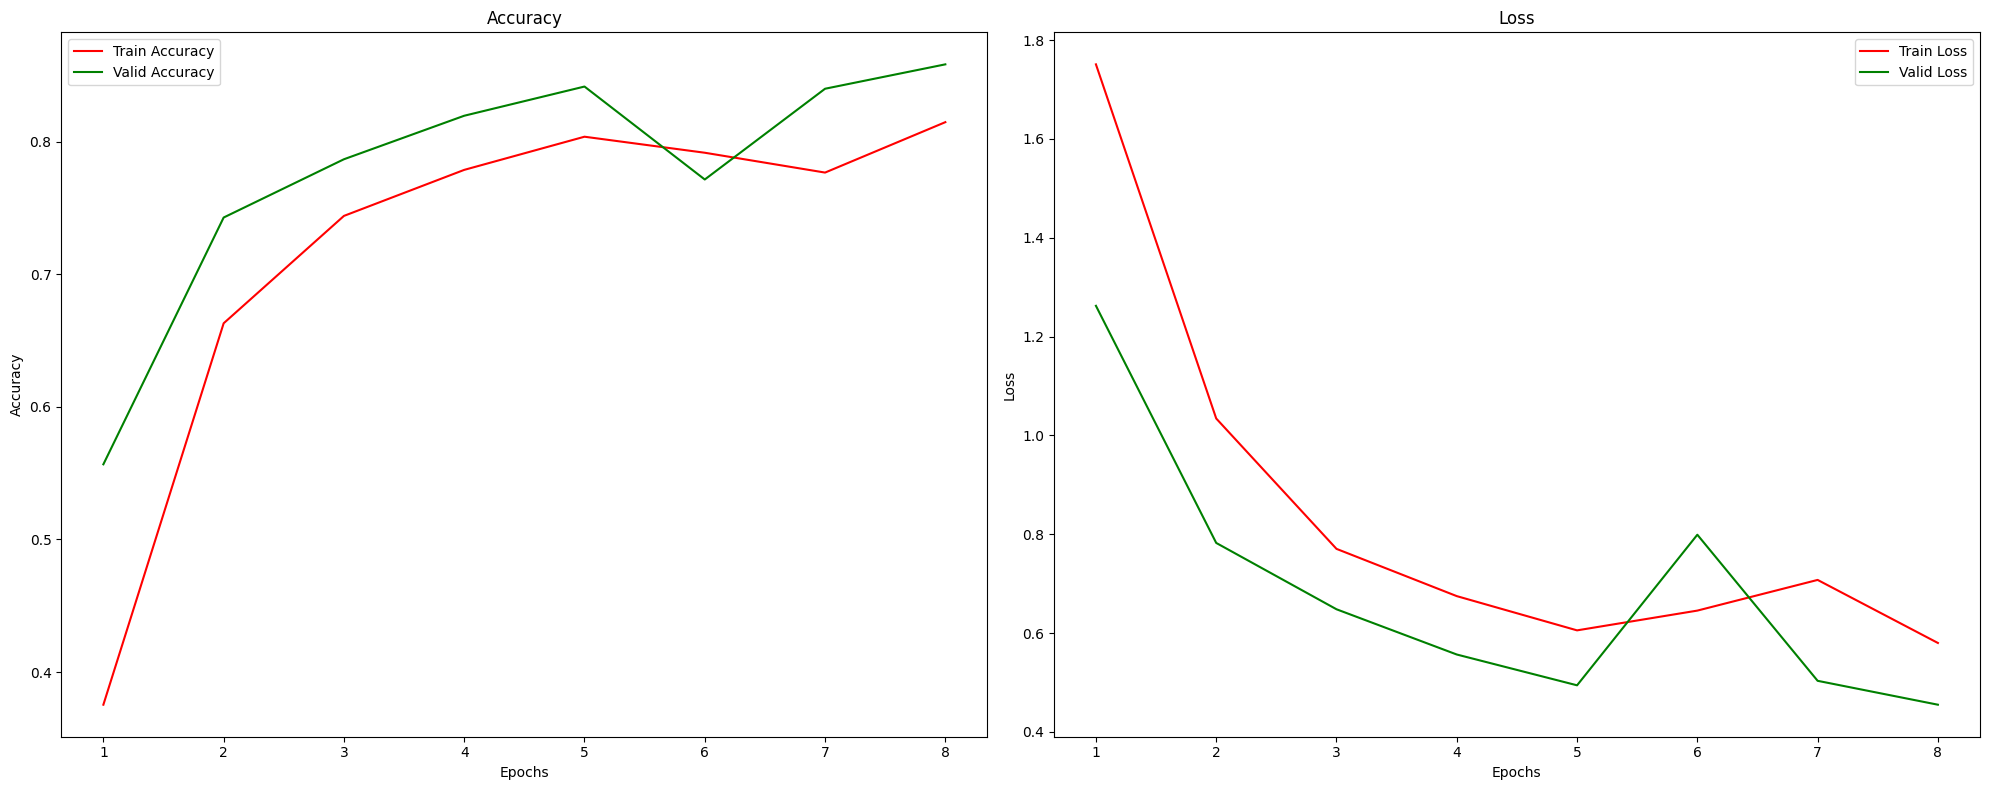

In [19]:
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = label_encoder.classes_


# Tahminleri alın
y_pred = model.predict(X_test)

# Tahminleri etiket formatına dönüştürün (one-hot encoding)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_categorical, axis=1)

# Sınıflandırma raporunu çıkarın
print(classification_report(y_true_labels, y_pred_labels,target_names=class_names))


9287/9287 [==============================] - 677s 73ms/step
                 precision    recall  f1-score   support

bilim-teknoloji       0.80      0.73      0.76     13741
 finans-ekonomi       0.75      0.60      0.67     13110
   kültür-sanat       0.60      0.58      0.59     19846
        magazin       0.92      0.92      0.92     97992
         sağlık       0.86      0.94      0.90     24599
        siyaset       0.85      0.94      0.89     61179
           spor       0.96      0.96      0.96     45714
         turizm       0.63      0.69      0.66     14360
          çevre       0.43      0.07      0.12      6636

       accuracy                           0.86    297177
      macro avg       0.76      0.71      0.72    297177
   weighted avg       0.85      0.86      0.85    297177



In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels,)

print(cm)


[[ 9983   191   243   146   433   146   158   284   874]
 [  210  7900    52    31    21   316    61   884  1106]
 [  501    74 11561  4351   293  1398   198   581   253]
 [  204   164  4827 90606   183   623   880   719   155]
 [ 1643    46   445   677 23002   282   169   189   142]
 [  699  2496  2177   861   524 57492   229  1521  1888]
 [  237    32   169   865    57   132 43685   190    70]
 [  151  2028   338   445    58   705   310  9857  1682]
 [  113   179    34    10    28    85    24   135   466]]


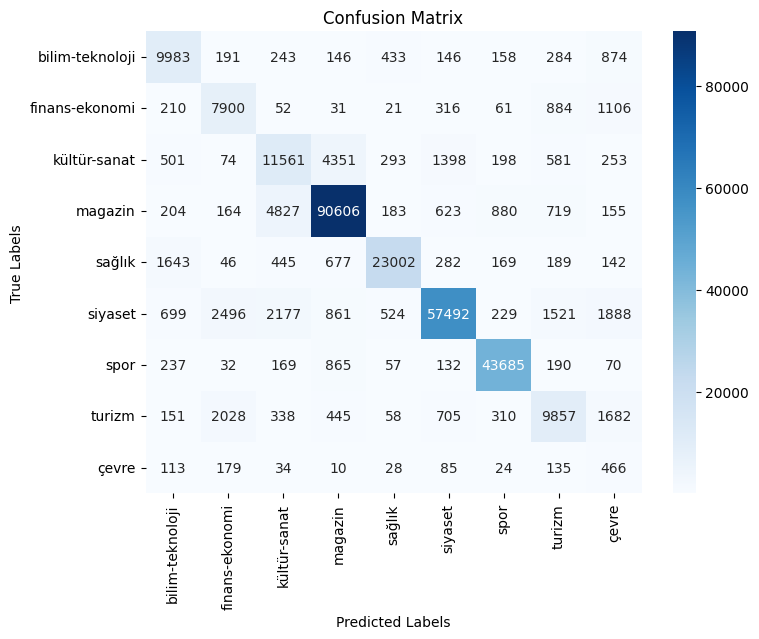

In [22]:
import seaborn as sns
class_names = label_encoder.classes_
# Confusion matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('INCwithSGDConfusionMatrix.png')
plt.show()

In [ ]:
model.save('nlp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import recall_score, precision_score

# Recall ve precision değerlerini hesaplayalım
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
precision = precision_score(y_true_labels, y_pred_labels, average='macro')

print(f"Recall: {recall}")
print(f"Precision: {precision}")

Recall: 0.7122953880668709
Precision: 0.7487741943885619


In [ ]:
from sklearn.metrics import recall_score, precision_score

# Recall ve precision değerlerini hesaplayalım
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')

print(f"Recall: {recall}")
print(f"Precision: {precision}")

Recall: 0.8610592340591634
Precision: 0.8463702982279953


In [ ]:
from google.colab import files

files.download('/content/nlp_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Stopwords verilerini indirin
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
!pip install JPype1
import jpype
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

In [ ]:
class Zemberek:
    def __init__(self):
        self.start_jvm()

    def start_jvm(self):
        if not jpype.isJVMStarted():
            jpype.startJVM(
                getDefaultJVMPath(),
                "-ea",
                "-Djava.class.path=/content/zemberek-full.jar",
                convertStrings=False,
            )

        TurkishMorphology = JClass("zemberek.morphology.TurkishMorphology")
        self.morphology = TurkishMorphology.createWithDefaults()

    def stop_jvm(self):
        shutdownJVM()

    def stem_word(self, word: str) -> str:
        result = self.morphology.analyzeAndDisambiguate(word).bestAnalysis()
        stems = [analysis.getStem() for analysis in result]
        return stems[0] if stems else ""


    def lemmatize_word(self, word: str) -> str:
        result = self.morphology.analyzeAndDisambiguate(word).bestAnalysis()
        lemmas = [analysis.getLemmas()[0] for analysis in result]
        return lemmas[0] if lemmas else ""


    def stem_sentence(self, sentence: str) -> List[str]:
        return [self.stem_word(word) for word in sentence.split()]

    def lemmatize_sentence(self, sentence: str) -> List[str]:
        return [self.lemmatize_word(word) for word in sentence.split()]

In [ ]:
stopwords_turkish = set(stopwords.words('turkish'))
stopwords_turkish.update(["bir", "kadar", "sonra", "kere", "mi", "ye", "te", "ta", "nun", "daki", "nın", "ten"])
silinecek_tokenler = ['ol', 'et', 'yap', 'ben', 'ver', 'al', 'de', 'gel', 'yıl', 'gün', 'kendi', 'çık', 'söyle', 'ara', 'iş', 'var', 'son', 'yer', 'gör', 'git', 'başla', 'ilk', 'bulun', 'başkan', 'konu', 'türkiye', 'kullan', 'yüz', 'çalış']
stopwords_turkish.update(silinecek_tokenler)

url_pattern = re.compile(r'https?://\S+')

def remove_urls(text):
    return url_pattern.sub('', text)

def remove_stopwords(text):
    return " ".join(word for word in text.split() if word.lower() not in stopwords_turkish)

def preprocessing(text):
    text = text.lower()

    text = remove_urls(text)

    text = re.sub(r'([.,])\s*', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\d', '', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'<.*?>', '', text)

    text = remove_stopwords(text)

    return text

# Örnek kullanım
# metin = "Örnek bir metin 123! İçerisinde https://example.com URL ve çeşitli <b>HTML</b> etiketleri ile."
# temizlenmiş_metin = preprocessing(metin)
# print(temizlenmiş_metin)


In [ ]:
#finas-ekonomi- yanlış
metin = "Asgari ücrete ek zam yapılacak mı? Asgari ücret ara zammı için kapıyı kapattı Asgari ücret ile geçinmeye çalışan milyonlarca vatandaş Temmuz ayı için ek zam beklentisi arttı. Asgari ücrete zam için Çalışma ve Sosyal Güvenlik Bakanı Vedat Işıkhan bir kez daha kapattı. Bakan Işıkhan  Aralık ayındaki düşüncemiz neyse aynı şekilde devam ediyor. Hiçbir ara zam gündemimizde yok  ifadesini kullandı. Türkiye’de hemen hemen her kesimin alacağı maaş zammının belirlenmesinde önemli bir etken olan asgari ücret zammı için yükselen enflasyon nedeniyle beklenti oluştu. Asgari ücret için ara zam yapılmayacağını açıklayan Bakan Işıkhan, bir kez daha kapıyı kapattı.ASGARİ ÜCRETE ZAM GELECEK Mİ?Çalışma ve Sosyal Güvenlik Bakanı Vedat Işıkhan asgari ücret ve emekli maaşlarına ilişkin açıklamalarda bulundu.Bakan Işıkhan, AK Parti TBMM Grup Toplantısı öncesinde gazetecilerin sorularını yanıtladı.Işıkhan asgari ücrete zam olmayacağını söylerken emekli maaşları için temmuza işaret etti.Işıkhan, asgari ücrete ilişkin soru üzerine, ekonomik verilerin iyi gittiğine dikkati çekerek,  Aralık ayındaki düşüncemiz neyse aynı şekilde devam ediyor. Enflasyonla ilgili verilerimiz oldukça güzel geliyor. Hiçbir ara zam gündemimizde yok  ifadesini kullandı. ASGARİ ÜCRET ERİMEYE DEVAM EDECEK Asgari ücretin yıl ortasında en az yüzde 25.4 oranında eriyeceğini ortaya koyuyor. Asgari ücrete yıl ortasında zam yapılmaması halinde 2024 sonunda asgari ücretin alım gücü yarı yarıya erimiş olacak. Hesaplamalar hem asgari ücrete hem de en düşük emekli aylığına temmuzda en az yüzde 25 oranında zam yapılmasının kaçınılmaz hale geldiğini gösteriyor. Merkez Bankası’nın anketine göre ilk 4 ayda yüzde 18.72 olan enflasyonun, mayıs ayında yüzde 3, haziran ayında da yüzde 2.54 daha artacak. Enflasyonun tahmin edilen rakamların etrafında oluşması halinde haziran sonunda tüketici enflasyonu yüzde 25.4’e ulaşacak.EN AZ 21.320 TL OLMALITemmuzda memur ve emeklilere gerçekleşen enflasyon hesaba alınarak zam yapılacağı için bu kesim kısmen de olsa enflasyon kaybını telafi edecek. Ancak asgari ücrete zam yapılmaması halinde, açlık sınırının da altına düşmüş olan asgari ücretlinin her 4 lirasından 1 lirası enflasyonla buhar olacak. Üstelik ikinci 6 ayda kayıp daha da artarak maaşın yaklaşık yarısını götürecek.  Enflasyon beklentilerine göre 17 bin 2 lira olan asgari ücretin reel alım gücü haziran sonunda 13 bin 558 liraya düşecek. İlk 6 aylık enflasyon kaybının telafi edilebilmesi için asgari ücretin 1 Temmuz’dan geçerli olmak üzere en az 21 bin 320 liraya çıkarılması gerekiyor. Zam yapılmaması halinde ise asgari ücretin bir miktar üzerinde maaş alanlarla birlikte en az 10 milyon çalışan, açlıkla karşı karşıya kalacak.DÖRT AYDA YÜZDE 18 ERİDİ Türkiye İstatistik Kurumu (TÜİK) ocak-nisan arasındaki 4 ayda tüketici fiyatlarının yüzde 18.72 arttığını hesapladı. TÜİK’in resmi enflasyonuna göre, iktidarın yıl ortasında zam yapmayacağını açıkladığı 17.002 liralık asgari ücretin alım gücü mayıs başı itibarıyla 2.681 lira eriyerek 14 .321 liraya geriledi.  Asgari ücretin alım gücü İstanbul Ticaret Odası’nın (İTO) hesabıyla 14.043 liraya, alternaif enflasyon hesabı yapan ENAG’a göre ise 13.285 liraya düştü. Mayıs ve haziran tüketici fiyat endeksindeki (TÜFE) artışla birlikte 6 aylık enflasyonun yüzde 25’lere ulaşması bekleniyor. Bu durumda asgari ücretin alım gücü 13.600 liraya kadar gerileyeceği için ara zam kaçınılmaz hale gelecek.İKİ KEZ ASGARİ ÜCRETE ARA ZAM YAPILDIEnflasyonun hızla yükselmesinin etkisiyle 2022 ve 2023 yıllarında asgari ücrete temmuz ayından geçerli olacak şekilde ara zam yapıldı.2022 yılının ocak ayında  4 bin 253 TL olan asgari ücret temmuz ayında yapılan yüzde 29,3'lük ara zamla birlikte 5 bin 500 TL'ye çıkartılmıştı.2023 yılının ocak ayında asgari ücret yüzde 54,5 artışla 8 bin 506 TL olarak belirlenmiş, 2023 yılının temmuz ayında ise asgari ücrete yüzde 34 oranında ara zam yapılmış ve asgari ücret 11 bin 402 TL olmuştu. 2024 yılının ocak ayında ise asgari ücret yüzde 49 artışla 17 bin 2 TL'ye çıkartılmıştı."
#spor - doğru
metin2 = "Aziz Yıldırım: Devletle kavga edemeyiz, hükümetle ederiz! Fenerbahçe'de eski başkan Aziz Yıldırım, yeniden adaylığını açıkladığı basın toplantısı öncesi salonda alkışlarla karşılandı. Fenerbahçe'yi yeniden şampiyon yapmak için aday olduğunu söyleyen Aziz Yıldırım'ın sözleri gündem yarattı. Fenerbahçe'de seçimli genel kurul öncesi başkanlığa yeniden aday olacağını açıklayan Aziz Yıldırım basın toplantısı düzenledi. Salona alkışlarla gelen ve 'Efsane döndü' tezahüratları ile karşılanan Yıldırım'ın açıklamaları Türkiye gündemine oturdu. Mevcut Başkan Ali Koç ile küs olmadıklarını, sadece fikir ayrılıkları olduğunu söyleyen Aziz Yıldırım teknik direktörlük konusunda Mourinho ile bir an önce anlaşılması gerektiğinin altını çizdi. İşte Aziz Yıldırım'ın toplantısından öne çıkan başlıklar:   ALTTAN YUKARI GİTMEYECEĞİZ  Bizi kim şampiyon yapmak istemiyor? İktidar mı, devlet mi? Hakemler mi, TFF Başkanı mı? Kim? Eğer bunlar birbirine bağlıysa, alttan yukarı gitmeyeceğiz! Yukarıdan söyleyeceğiz!   HÜKÜMETLE MÜCADELEMİZİ YAPARIZ!   Devlet ayrı, hükümet ayrı! Biz devletle kavga edemeyiz. Ama hükümetle haklı olduğumuzda mücadele yaparız, yaptık! FETÖ konusunda iç içeydiler, hep beraber yürüdük. Onun için açık olacağız.  BELA OLDUM, YİNE GELİYORUM!'  Kimseyle kavga etmeyeceğim dedim ama benimle kavga ederlerse ederim. 6 sene önce ben ayrılırken herkes 'Aziz Yıldırım gitti Türk futbolu kurtuldu.' dediler. Maalesef bugün geldik, 'Aziz Yıldırım gelsin Türk futbolunu kurtarsın.' diyorlar. Böyle bir memleket. 1 oyla beni seçtiniz, sağ olun. Sonrasında 20 sene Fenerbahçe'ye bela oldum. Yine geliyorum!   BEN KİMSENİN ADAMI DEĞİLİM   Yiğit Bulut'un trolleri varmış, AKP beni destekliyormuş falan... Ben kimsenin adamı değilim! Ben hiçbir partinin adamı değilim, olmam da! O troller de bu işlere girmesin. Ben duymam. Sakın bu işlere girmeyin. Hükümet desteği ile değil, bir laf uğruna geliyorum. 'Ben varken Fenerbahçe'yi şampiyon yapmayacaklar' lafı üzerine.. İktidar duruyor, TFF Başkanı duruyor, hakemler duruyor.. Çocuklar ağlıyor, öyle diyorlardı   BEN ALİ KOÇ İLE KÜS DEĞİLİM  Ben Ali Koç ile küs değilim. Fikirlerimiz farklı. Gelip divanda elimi sıksaydı 'hayır sıkma' mı diyecektim? Küs filan değilim kardeşim   ATATÜRK'Ü İYİ OKUYUN   Ben Atatürk'çüyüm! Ben laikim, ben Cumhuriyetçiyim! Hepinize tavsiye ediyorum. Atatürk'ü iyi okuyun. Yaptığı ilklere bakalım ve onları uygulamaya çalışalım. İşinize geliyorsa uygularsanız, işinize gelmiyorsa uygulamazsınız. Ama bu kadar kullanmayın. Herkes için söylüyorum. Bazı bizdekilere de söylüyorum. Gidenlere...  DEVLETTEN ALACAĞIMIZ VAR   Devletten maddi ve manevi alacağımız var. Hepimiz perişan olduk, şikeci damgası yedik. Fenerbahçe'nin borcu kadar alacağı var. Bunu masada çözmemiz lazım, mahkemede çözemeyiz. Ben seçilirim, seçilmem. 72 yaşındayım. Allah ne kadar ömür verir bilmem. 3 sene için geleceğim. 3 seneden fazla yapamam.   MOURINHO İLE ANLAŞIRSAK GELECEK   Mourinho ile 2 saat yüz yüze konuştum. O anlattı, ben anlattım. Hiç para konuşmadık. Fenerbahçe'nin maçlarını izlediğini söyledi. Bir aday iletişime geçmiş, mevcut başkan menajerleri göndermiş. Jose Mourinho şartlarda anlaşırsak gelecek. Ama rahat bırakmıyorsunuz, burayı takip ediyor. Suudi Arabistan'a gitmiyor, rahat olun. Bahreyn'e iki konferansa gidecek, 2 milyon dolar... Anlayın yani değerli basın, olumlu olun. Zeljko Obradovic ile 5 aydır hiç konuşmadım. Antrenör gayet iyi, iyi olan şey bozulmaz. Kötü olursa, bakılır.   KAYBEDERSEM YARI PARASINI ÖDEYECEĞİM Bu yönetime teklifim; Eğer onlar da Mourinho ile çalışmayı düşünüyorlarsa gelsinler beraberce imzayı atalım. Ben seçilirsem benimle devam, o seçilirse onunla devam. Biz kaybedersek Mourinho'nun parasının yarısını da ödemeyi taahhüt ediyorum. Bana oy vermeyenlere teşekkür ederim, beni hayata döndürdüler ve para kazandım.   BENİM DÖNEMİMDE GALATASARAY HİKAYEYDİ   Galatasaray'ın saha dışında çok güçlü olduğunu nerede söyledim? Atıyorsunuz abi... Benim olduğum dönemde Galatasaray hikayeydi! Biz FETÖ ile mücadele ettik. Devletin içine sızdılar, devlet ile mücadele ettik. Onlarla mücadele etmekten, başka şey ile mücadele edemedik. En son Ankara'ya gittim ve 'Hapis yatmaya razıyım, karar verin' dedim. Verdiler!   ÇOK PARA HARCADILAR   Seçilirsem çok önemli bir sürprizim var: Kalamış'ta güneşin doğmadığını, battığını söyleyeceğim. Ramos'u alın, Dzeko'yu alın dedik. Biz Anelka, Ortega'yı getirdik. Gidiyorsunuz, ilk 1-2 sene çok kötü transferler yapıyorsunuz. Çok para harcadılar!   HEDEFİM TÜRKİYE'DE ŞAMPİYONLUK'  Benim hedefim Türkiye'de şampiyonluk. Ne Şampiyonlar Ligi kardeşim! İnsanlara hayal satmayacağız. Benim hedefim ilk önce Türkiye'de şampiyonluk. Sonrasına bakarız   BÜTÜN FETÖCÜ'LERİ AFİŞE EDECEĞİM   Sporda FETÖ operasyonu yapıldı mı? Hakemlerde yapıldı mı? Yönetim kurullarında yapıldı mı? Basında da yapılması lazım. 3 Temmuz sabahı bütün yemi alıp anlatan adam, bugün Halk TV'de program yapıyor. Geldiğimde bunları hep kocuşacağım. Bütün FETÖ'cüleri afişe edeceğim.   ŞAMPİYONLUKTAN BİRLİKTE ETTİK  Derdim Fenerbahçe'nin şampiyon olması. Dört sene Fenerbahçe şampiyon olamadı, nedenini biliyorum. Mahkemeler... Ben ve dava arkadaşlarım her gün mahkemeye gittik. Mahkemeler uğraştık ve Fenerbahçe'ye zarar verdik. Bunu biliyoruz. Sonra kombine almayın, forma almayın, maça gitmeyin gibi şeyler denildi. Hep beraber Fenerbahçe'yi şampiyonluktan ettik, hep beraber...  HAPİSTEYKEN KULÜBÜ HALKA AÇTIM   Fenerbahçe kurumsal bir yapı, dışardan adam getirip kulübü incelettiler. Böyle bir şey olabilir mi? Dün Fenerbahçe'nin durumunu dağıttlar, belgeleri arkadaşlarımız inceliyor. Varsa düşüncemiz söylerim. Fenerbahçe'de para sorunu olmaz! Ben neden kulübü halka açtım? Ben istesem bunu yapmam, ölene kadar başkan olurdum. Hapisteyken kulübü halka açtım, 1 milyon üye olsun istedim. Anadolu'da Fenerbahçelileri bir araya getirecek binalar açılmasını istedim, birkaç yerde yaptık. Ancak kapattılar.   Fenerbahçe, Türkiye'nin en büyük sivil toplum örgütlerinden biridir. Fenerbahçe'nin istemediği bir şey Türkiye'de olmaz! Ne zaman? Bir araya gelirsek! Beraber olmazsak, hiçbir şey olmaz Fenerbahçe'den. Türkiye'nin Kuva-yi Milliye'si Fenerbahçe Spor Kulübü'dür.   KEYFİM YERİNDEYDİ, NEDEN ADAY OLDUM?   Başkanlığa hiç niyetim yoktu. Keyfim yerinde, para da kazanıyordum. İşlerim tıkırında ama Fenerbahçe'de bazı sıkıntılar var, onu gördüm. Arkadaşlarıma 'Biriniz aday olun, yürüyelim' dedim ama 'Sen varken olmayız' dediler. O zaman mecbur kaldım. 20 sene başkanlık yaptım, zor günlerde 6 şampiyonluk yaşadık. Para konuşmadık.   NİHAT ÖZDEMİR FENERBAHÇE'NİN DEĞERİYDİ Nihat Özdemir... 12 sene benim yanımda ikinci başkanlık yaptı. Bu kulübe hizmet etti. Aralarındaki husumet bugünün husumeti değil, 2011 yılından. Bilmediğiniz konular var. Değerdi değer, Fenerbahçe'nin değeriydi. TFF başkanı oldu. Adama salladılar salladılar, o da Fenerbahçe'den istifa etti. Al çiçeği eline, git 'Başkan bize bunu bunu yapıyorlar, bunu çöz.' de. Niye geldin mi diyecekti?"
#bilim-teknoloji
metin3 = "Rockstar Games, 10 yılın ardından Grand Theft Auto serisinin yeni oyunu GTA 6‘yı duyurmak için geçtiğimiz günlerde ilk fragmanı paylaştı. Bu fragman, internet üzerinde o kadar büyük ilgi gördü ki oyun henüz piyasaya sürülmemiş olmasına rağmen şirkete rekor kırdırdı. Son gelişmelere göreyse GTA 6 fragmanında kullanılan şarkı çok konuşuldu. Rockstar Games, GTA 6‘nın tanıtım fragmanını 5 Aralık‘ta YouTube üzerinde yayınladı. On milyonlarca kez izlenen video, Guinness Rekorlar Kitabı’na bile girdi. Bununla beraber bu videoda kullanılan şarkı da çok dinlenmeye başladı. Aktarılan bilgilere göre GTA 6 fragmanında kullanılan, 2017 yılında hayata gözlerini yuman Tom Petty tarafından söylenen “Love Is A Long Road” adlı şarkı, video yayınlandıktan sonra sonra dijital müzik servisi Spotify‘da önceki haftaya göre yüzde 36 bin 979 daha fazla dinlendi. Böylelikle en çok çalınan parçalar listesine adını yazdırmayı başardı. Söz konusu şarkının YouTube platformundaki dinlenme sayısının da arttığı görülüyor. Bunun yanı sıra GTA 6 fragmanı, ilk 24 saatte en çok izlenme rekoru da kırdı. Geçtiğimiz günlerde çıkan bir habere göre video, yayınlanmasının ardından daha 24 saat bile geçmeden 70 milyondan fazla izlendi. Bu rekoru daha önce ABD’li YouTuber MrBeast, 59.4 milyon izlenmeye sahip “7 Days Stranded At Sea” (“7 Gün Denizde Mahsur Kaldık”) videosu ile elinde tutuyordu. Ünlü YouTuber da X (Twitter) hesabı üzerinden bunu paylaştı. Rockstar Games‘in GTA 6 için çıkış yılı olan 2025’e kadar birkaç fragman daha yayınlaması bekleniyor. Peki siz bu konu hakkında neler düşünüyorsunuz? Yeni oyundan beklentileriniz neler? Görüşlerinizi aşağıdaki Yorumlar kısmından bizimle paylaşabilirsiniz."
#siyaset- doğru
metin4 = "Bahçeli: Kanun dışı ilişki ağlarının farkındayız Milliyetçi Hareket Partisi (MHP) Genel Başkanı Devlet Bahçeli, görevden uzaklaştırılan emniyet görevlilerine ilişkin  Olan biten tüm kanun dışı irtibat ve ilişki ağlarının farkındayız. Birkaç emniyet müdürünün açığa alınmasıyla geçiştirilemeyecek bir komplo devrededir; nitekim hedef MHP, AK Parti, Cumhur İttifakı ve son tahlilde Türkiye'dir.  dedi. MHP Genel Başkanı Devlet Bahçeli, partisinin Türkiye Büyük Millet Meclisi (TBMM) grup toplantısında konuştu. Bahçeli, 14. olağan büyük kurultayda kabul edilen yenilenmiş parti programlarında yer alan dış politika esaslarına değindi. Bölgesel veya küresel mahiyetli sorunların uluslararası hukuk çerçevesinde adil ve kalıcı çözümlere kavuşturmanın dış politikalarının özünü teşkil ettiğini vurgulayan Bahçeli, uluslararası karar alma mekanizmalarının baştan ayağa revize edilmesinin, artan reform çağrılarının mutabakata bağlanmasının küresel istikrarın tesisi bakımından artık ertelenemez bir mecburiyet olduğunu söyledi. Bahçeli, Birleşmiş Milletler (BM) Genel Kurulu'nda, Filistin'in üyeliğinin Güvenlik Konseyi'nde tekrar görüşülmesi ve bu ülkeye bazı ilave haklar tanınmasını öngören tasarının onaylandığını anımsatarak, şöyle devam etti: Uluslararası toplum ezici çoğunlukla Filistin'in yanında durmuştur. Küresel vicdan Filistin halkının meşru mücadelesine destek verirken, İsrail saldırılarına bir nevi tepki göstermiştir. Filistin'in üyelik tasarısının BM Genel Kurulu'nda onaylanması karşısında İsrail temsilcisinin çıldırmış gibi Birleşmiş Milletler Şartı'nın bir kopyasını imha etmesi, kararın terör için bir ödül olduğunu ileri sürmesi siyonist vandallığa uygun düşen bir saygısızlık ve seviyesizlik olarak kayıtlara geçmiştir."
#magazin - doğru
metin5 = "Oyuncu Yasemin Allen, meslektaşı Murat Cemcir ile bir programa katıldı. Allen, sorulan bir soruya Seranay Sarıkaya cevabını vererek dikkat çekti. Yasemin Allen ile Murat Cemcir Yasemin Şefik'in 'Uyduruk Sonlar' adlı talk show programına konuk oldu. Yasemin Şefik oyunculara Diyelim ki beraber bir dizide sevgiliyi oynuyorsunuz ve sizi ayıran kişi kim olurdu? Serenay Sarıkaya mı, Kıvanç Tatlıtuğ mu? diye sordu. BİRAZ SKANDAL OLACAK Yasemin Allen Biraz skandal olacak. Serenay diyorum. 'Seni Serenay için terk ediyorum yanıtını verdi. Murat Cemcir de Ben de aynı şeyi yapardım dedi."
#kültür-sanat -yanlış
metin6 = "2024'ün ilk 3 ayında en çok izlenen 10 filmden 9'u yerli yapım oldu. Türkiye'de 2024'ün ilk üç ayında en çok izlenen filmler ve seyirci rakamları... 2024 yılında vizyona giren filmlerin ne kadar izlendiği açıklandı. Box Office Türkiye'den derlenen bilgilere göre, 107 yeni filmin vizyona girdiği 3 ayda, toplam izleyici sayısı 14 milyon 252 bin 971'e ulaştı.Türkiye'de 2024'ün ilk üç ayında en çok izlenen filmler ve seyirci rakamları şöyle...Rafadan Tayfa 4: HayrimatörTRT Çocuk'un kahramanlarının geçmişin ve geleceğin ortasında dev bir maceraya hazırlanmalarını konu alan  Rafadan Tayfa 4: Hayrimatör , en çok izlenen filmler arasında ilk sırada yer aldı. Arzu Yurtseven'in kaleme aldığı, yönetmenliğini ve müziklerini İsmail Fidan'ın üstlendiği yapımı 2 milyon 795 bin 662 kişi izledi. Filmden elde edilen gelir ise 305 milyon 423 bin liraya ulaştı.Sadece üstün zekalı öğrencilerin kabul edildiği bir bilim teknik okuluna kabul edilen Hayri, zamanının çoğunu “Yüzyılın İcadı” olan dev robot Hayrimatör'e harcar. Ancak Hayri, bir mühendislik harikası olan Hayrimatör'ün çalışmasını sağlayacak güç kaynağını bir türlü elde edemez.LohusaGupse Özay'ın senaryosunu yazıp başrolünde oynadığı  Lohusa , yılın en çok izlenen ikinci filmi oldu. Kıvanç Baruönü'nün yönettiği filmi 2 milyon 124 bin 610 kişi izlerken, yapımdan elde edilen gelir ise 281 milyon 362 bin lira oldu. Özay'ın yanı sıra Onur Gürçay, Hazal Türesan, Esra Ruşan, Elif Nur Kerkük, Cihan Albayrak ve Alper Baytekin'in rol aldığı film, yeni ebeveyn olan bir anne ve babanın ilk 40 günde başlarına gelen komik olayları anlatıyor.Kolpaçino 4 4'lükŞafak Sezer'in, senaryosunu yazdığı  Kolpaçino 4 4'lük , 2 milyon izleyici sınırını aşarak, en çok izlenen filmler arasında üçüncü sırada yer aldı.Kendisine haksızlık eden dostlarıyla hesaplaşmaya karar veren Özgür'ün hikayesini beyaz perdeye taşıyan yapım, 2 milyon 100 bin kişi tarafından izlendi. Filmden elde edilen gelir ise 240 milyon 954 bin liraya ulaştı.3391 KilometreYazar Beyza Alkoç'un  3391 Kilometre  adlı kitabından sinemaya uyarlanan  3391 Kilometre , en çok izlenen 4. film oldu. Kreatif direktörlüğünü Ömer Faruk Sorak'ın üstlendiği, yönetmen koltuğunda Deniz Enyüksek'in oturduğu yapımı 921 bin 979 kişi izledi. Filmden elde edilen hasılat ise 113 milyon 437 bin lira oldu.Fulya Özcan'ın senaryosunu kaleme aldığı, Paris, İstanbul ve İzmir'de çekilen film, birbirlerinden çok uzakta olmalarına rağmen sevginin güçlü bağını hissedebilen iki gencin hikayesini konu alıyor.Kral Şakir: Devler UyandıKral Şakir serisinin son filmi  Kral Şakir: Devler Uyandı , listede 5. sırada yer aldı. Nemrut Dağı'nın kültürel zenginliklerini çocukların gözünden beyaz perdeye aktaran yapımı 584 bin 647 kişi seyretti, elde edilen gelir ise 77 milyon 332 bin liraya ulaştı.Atatürk 1881- 1919Yılın ilk günlerinde vizyona giren  Atatürk 1881-1919 , 563 bin 582 izleyiciye ulaşarak, yılın en çok izlenen 6. filmi oldu. Filmden 73 milyon 265 bin lira gelir elde edildi. Aras Bulut İynemli'nin Mustafa Kemal Atatürk'ü canlandırdığı Atatürk serisinin ikinci filmi, Çanakkale Savaşı'na ve 1919 yılına kadar olan süreci işliyor.Mehmet Ada Öztekin'in yönetmen koltuğunda oturduğu filmde, İynemli'ye Songül Öden, Sarp Akkaya, Esra Bilgiç, Celile Toyon ve Darko Peric eşlik etti.Dune: Çöl Gezegeni Bölüm İkiDenis Villeneuve'un yönettiği  Dune: Çöl Gezegeni Bölüm İki , yılın ilk 3 ayında en çok izlenen 7. film olarak listeye girdi. Macera, bilim kurgu ve aksiyon meraklılarının ilgisini çeken yapımı izleyenlerin sayısı 525 bin 360 olurken, elde edilen gelir ise 99 milyon 970 bin liraya ulaştı.Listedeki tek yabancı yapım olan filmde Timothee Chalamet, Zendaya, Rebecca Ferguson, Javier Bardem, Josh Brolin, Austin Butler, Florence Pugh, Dave Bautista, Christopher Walken, Stephen McKinley Henderson ve Lea Seydoux rol aldı.Kardeş TakımıAnne babalarının aslında birer gizli ajan olduklarını öğrenen kardeşlerin hikayesini işleyen komedi filmi  Kardeş Takımı , en çok izlenen 8. yapım oldu. Filmi 449 bin 388 kişi izlerken, elde edilen hasılat ise 56 milyon 43 bin lirayı buldu.Fırat Albayram, Ceyda Kasabalı, Çağan Efe Ak, Ecrin Su Çoban, Mehmet Aybars Kaya, Gece Işık Demirel, Mert Denizmen, Gülhan Tekin ve Melis İşiten gibi isimlerin rol aldığı filmi Mustafa Kotan yönetti.Mutluyuzİbrahim Büyükak'ın yönetmenliğini yapıp başrolünü Yasemin Sakallıoğlu ile paylaştığı  Mutluyuz  filmini 448 bin 810 kişi izledi. Komediseverleri sinema salonlarına çeken yapım, en çok izlenen 9. film oldu.Boşanma aşamasındaki bir çiftin hayatını ele alan yapımdan elde edilen gelir ise 55 milyon 760 bin lira oldu.Zaferin RengiAbdullah Oğuz imzalı  Zaferin Rengi , 268 bin kişi tarafından izlenerek, yılın ilk üç ayında en çok izlenen 10. yapım oldu.Film, Milli Mücadele'nin zaferle sonuçlanmasının arifesinde, işgal altındaki İstanbul'da, Harington Kupası'nda Birleşik Krallık işgal kuvvetleri karma futbol takımına karşı, Fenerbahçe'nin elde ettiği zaferi, istiklal mücadelesinde yer alan dönemin önemli isimleri eşliğinde beyaz perdeye yansıtıyor. Yapımdan 40 milyon 659 bin lira gelir elde edildi."
#sağlık - yanlış
metin7 = "Hastanelerde  Onaylı Randevu  dönemi Sağlık Bakanlığınca hayata geçirilen  Onaylı Randevu  sistemiyle hastalar, randevu tarihinden bir gün önce saat 20.00'ye kadar randevusuna onay verecek veya gelemeyeceğini Merkezi Hekim Randevu Sistemi'ne (MHRS) bildirecek. Hastalar öncelikle, Sağlık Bakanlığına bağlı sağlık kuruluşlarından, MHRS internet sitesi, mobil uygulama veya  ALO 182  çağrı merkezinden randevu oluşturacak. Yeni uygulamayla randevu tarihinden bir gün önce saat 20.00'ye kadar hastaların randevusuna onay vermesi veya gelemeyeceğini sisteme bildirmesi gerekecek. Üzerinde herhangi bir işlem yapılmayan randevular, bir gün önce saat 20.00'de otomatik olarak iptal edilecek. Bu durumda kişi tekrar randevu alabilecek, herhangi bir kısıtlama uygulanmayacak. Randevusunu onayladığı halde gitmeyen kişilerin ise aynı branşta 15 gün boyunca yeni randevu alması kısıtlanacak. Uygulamadan 65 yaş üstü hastalar ve kanser hastaları muaf tutulacak, bu gruptaki hastalar, her zaman randevu alabilecek.Onaylı Randevu Sistemi'nde, randevuların iptal edilmesinin ardından boş kalan kapasite için sistemden randevu alamayan ancak talep bırakmış hastalara ulaşılacak, öncelik talepte bulunan hastalara verilecek."
#turizm - yanlış
metin8 = "Muğla'nın Milas ilçesinde mavi-beyaza boyanan kaldırım taşları, Yunan bayrağına benzediği gerekçesi ile yeniden değiştirildi.Milas'a bağlı Beçin beldesinin Soğukkuyu semtinde halk vebelediyeişbirliğinde 'mavi-beyaz' boyanan kaldırımlar, Yunan bayrağını andırdığını düşüncesi ile tepki gördü. MilasBelediyesi ve BeçinBelediyesi sınırlarının belli olması amacıyla farklı bir renge boyanan tretuar taşları sorun oldu. Tepkiler üzerine tretuar taşlarının rengibelediyeekipleri tarafından 'turuncu' olarak değiştirildi.Soğukkuyu semtinde kaldırım taşlarındaki değişiklikle ilgili Beçin'i seven gönüllüler tarafından oluşturulan birinternetsitesinde şu açıklamalara yer verildi; Beldemiz Soğukkuyu Semti'nin kaldırımlarının boyanması, çiçeklendirilmesi, ağaçlandırılması da gönüllü semt sakinlerinin maddi ve fiziki katkıları ile yapılmıştır. Hatta sulama işleri dahi semt sakinlerinin katkıları ile devam etmektedir. Milas ile BeçinBelediyesınırının birbirinden ayrılması amacıyla taşların renginin farklı olması düşünülmüş ve mavi rengin gözleri ve insanı dinlendirmesi ve hoş gözükmesi düşüncesi ile mavi ve beyaz boyanmaya başlanılmıştır.Ancak bazı kesimler, tretuar taşlarının rengini Yunan bayrağına benzetince hemen boya rengi değiştirilmiştir. Vatan toprağına sahip çıkmak mı daha önemli, göze hitap eden ancak hiç anlamı yokken Yunan Bayrağına benzetilip değiştirilmesi istenen boyanın rengine takmak mı? "
#çevre - yanlış
metin9 = "Neom projesi: Suudi güvenlik güçlerine ekolojik kent inşaası için 'öldürme izni verildiği' iddia edildi. Suudi Arabistan'da onlarca Batılı şirketin desteğiyle inşa edilen ekolojik şehir projesi Neom için çöldeki çalışmalar devam ediyor. BBC'nin eski bir istihbarat yetkilisinden aldığı bilgiye göre şehrin inşası için bölgedeki arazileri boşaltmaya çalışan Suudi yetkililer, güvenlik güçlerine evlerini terk etmeyi reddedenleri gerekirse vurarak öldürmeleri emrini verdi. Albay Rabih Alenezi, Neom adı verilen proje kapsamındaki The Line (Hat) isimli dikey şehrin inşası için bölgedeki köylüleri evlerinden çıkarma emri aldığını söyledi. Evini terk etmeyi reddeden bir kişi vurularak öldürüldü. Suudi hükümeti ve Neom projesi yetkilileri bu iddialarla ilgili sorulara yanıt vermeyi reddetti."

In [ ]:
zemberek = Zemberek()

metin = preprocessing(metin9)
lemma = zemberek.lemmatize_sentence(metin)
lemma = [str(word) for word in lemma]

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts([metin])
sequences = tokenizer.texts_to_sequences([' '.join(lemma)])
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=500,  padding='post')


pred = model.predict(padded_sequences)

print(pred)

predicted_class_index = np.argmax(pred)

predicted_class_name = class_names[predicted_class_index]

print("Predicted class name:", predicted_class_name)


1/1 [==============================] - 0s 75ms/step
[[0.07330864 0.10459876 0.104866   0.13065742 0.05981656 0.28043675
  0.05242225 0.09109528 0.10279828]]
Predicted class name: siyaset


In [23]:
!pip install streamlit -q
!pip install JPype1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 3.2 MB/s eta 0:00:00


In [24]:
!wget -q -O - ipv4.icanhazip.com

34.134.59.197


In [39]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.134.59.197:8501

npx: installed 22 in 1.451s
your url is: https://social-pants-look.loca.lt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
I|22:38:12.782|Root lexicon created in 288 ms.                                                                     | DictionarySerializer#getDictionaryItems
I|22:38:12.784|Dictionary generated in 339 ms                                                                      | RootLexicon#defaultBinaryLexicon
I|22:38:13.098|Initialized in 716 ms.                                                                              | TurkishMorphology#createWithDefaults
2024-05-17 22:38:13.146 
════════════════════════════════════════════════
deprecation.showfileUploaderEncoding IS NO LONGER SUPPORTED.

deprecation.showfileUploaderEncoding has been deprecated and will be

In [40]:
!pip install pyngrok

In [41]:
!ngrok config add-authtoken 2gbl5HD2WyK9N3a78YbQiyVS7S4_7Pz6KgT1PcqSoDe14w8Bk

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [45]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [46]:
from pyngrok import ngrok
url = ngrok.connect(8501)
url

<NgrokTunnel: "https://6dea-34-134-59-197.ngrok-free.app" -> "http://localhost:8501">

In [47]:
!cat /content/nohup.out




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.134.59.197:8501

  Stopping...
Traceback (most recent call last):
  File "/usr/local/bin/streamlit", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/streamlit/web/cli.py", line 234, in main_run
   

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
import jpype
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
from typing import List
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  ----------------Metin Önişleme-----------------
stopwords_turkish = set(stopwords.words('turkish'))
stopwords_turkish.update(["bir", "kadar", "sonra", "kere", "mi", "ye", "te", "ta", "nun", "daki", "nın", "ten"])
silinecek_tokenler = ['ol', 'et', 'yap', 'ben', 'ver', 'al', 'de', 'gel', 'yıl', 'gün', 'kendi', 'çık', 'söyle', 'ara', 'iş', 'var', 'son', 'yer', 'gör', 'git', 'başla', 'ilk', 'bulun', 'başkan', 'konu', 'türkiye', 'kullan', 'yüz', 'çalış']
stopwords_turkish.update(silinecek_tokenler)

url_pattern = re.compile(r'https?://\S+')

def remove_urls(text):
    return url_pattern.sub('', text)

def remove_stopwords(text):
    return " ".join(word for word in text.split() if word.lower() not in stopwords_turkish)

def preprocessing(text):
    text = text.lower()

    text = remove_urls(text)

    text = re.sub(r'([.,])\s*', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\d', '', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'<.*?>', '', text)

    text = remove_stopwords(text)

    return text

#-----------------------Zemberek-------------------------

class Zemberek:
    def __init__(self):
        self.start_jvm()

    def start_jvm(self):
        if not jpype.isJVMStarted():
            jpype.startJVM(
                getDefaultJVMPath(),
                "-ea",
                "-Djava.class.path=/content/zemberek-full.jar",
                convertStrings=False,
            )

        TurkishMorphology = JClass("zemberek.morphology.TurkishMorphology")
        self.morphology = TurkishMorphology.createWithDefaults()

    def stop_jvm(self):
        shutdownJVM()

    def stem_word(self, word: str) -> str:
        result = self.morphology.analyzeAndDisambiguate(word).bestAnalysis()
        stems = [analysis.getStem() for analysis in result]
        return stems[0] if stems else ""


    def lemmatize_word(self, word: str) -> str:
        result = self.morphology.analyzeAndDisambiguate(word).bestAnalysis()
        lemmas = [analysis.getLemmas()[0] for analysis in result]
        return lemmas[0] if lemmas else ""


    def stem_sentence(self, sentence: str) -> List[str]:
        return [self.stem_word(word) for word in sentence.split()]

    def lemmatize_sentence(self, sentence: str) -> List[str]:
        return [self.lemmatize_word(word) for word in sentence.split()]


zemberek = Zemberek()


# Streamlit uygulama ayarları
st.set_option('deprecation.showfileUploaderEncoding', False)

@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('/content/nlp_model.hdf5')
    return model

model = load_model()

tokenizer = Tokenizer()
max_length = 500  # Maksimum sequence uzunluğu
padding_type='post'
truncating_type='post'

class_names = ["bilim-teknoloji", "finans-ekonomi", "kültür-sanat", "magazin", "sağlık", "siyaset", "spor", "turizm", "çevre"]

# Streamlit uygulaması

st.write("""
         # Haber Metni Sınıflandırma
         """)

# Kullanıcıdan doğrudan metin girmesini isteyin
text_input = st.text_area("Lütfen bir haber metni girin")

if st.button("Tahmin Et"):
    if text_input:
        st.write("Girilen metin:")
        st.write(text_input)

        # Ön işleme
        processed_text = preprocessing(text_input)
        st.write("İşlenmiş metin:")
        st.write(processed_text)

        # Zemberek ile lemmatization
        st.write("Kökenler (Lemmatization):")
        lemmatized_sentence = zemberek.lemmatize_sentence(processed_text)
        lemmatized_text = " ".join(lemmatized_sentence)
        st.write(lemmatized_text)

        # Tokenize ve Pad İşlemleri
        tokenizer.fit_on_texts([lemmatized_text])
        sequences = tokenizer.texts_to_sequences([lemmatized_text])
        st.write("Tokenized Sequences:")
        st.write(sequences)
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

        # Tahmin yap
        prediction = model.predict(padded_sequences)
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]

        st.write("Tahmin edilen sınıf:", predicted_class_name)
        st.write("Tahmin olasılıkları:", prediction)

